<a href="https://colab.research.google.com/github/JMurb/JMurb.github.io/blob/main/RuncibleSpoonClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 35.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incom

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'b9de02b731604e1693dfd9e232a240e9')

In [ ]:
# results = search_images_bing(key, 'grizzly bear')
# ims = results.attrgot('contentUrl')
# len(ims)

In [4]:
utensil_types = 'fork','spoon','runcible spoon'
path = Path('utensils')

In [5]:
if not path.exists():
    path.mkdir()
    for o in utensil_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
fns = get_image_files(path)
fns

(#410) [Path('utensils/runcible spoon/397c45f2-2dbb-44bc-b856-7284eac1ab9f.jpg'),Path('utensils/runcible spoon/11f58ab2-31fc-4835-9c10-ddde90f7ccd7.jpg'),Path('utensils/runcible spoon/a11a727e-d55e-4f86-8796-c3000052dc02.jpg'),Path('utensils/runcible spoon/61a0afc4-90c4-4f90-93cc-d34e9179e4a8.jpg'),Path('utensils/runcible spoon/33c3ed2e-9720-4c8e-a27f-531ee1a2c2a1.JPG'),Path('utensils/runcible spoon/6da601a9-e229-494e-a358-51c1ab2b6795.jpg'),Path('utensils/runcible spoon/76994c76-fb43-4d79-94d2-4d098fc139a6.JPG'),Path('utensils/runcible spoon/27b64b1c-77a8-402a-91fc-61d3cb0f3bcf.jpg'),Path('utensils/runcible spoon/e3776814-02a9-460b-a545-806e6469c4fe.jpg'),Path('utensils/runcible spoon/d4834aaf-18f7-47cd-838f-1a562b5b16d8.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#21) [Path('utensils/runcible spoon/ff76183d-8c9b-484d-b91f-31567eb60132.jpg'),Path('utensils/runcible spoon/c3629a0f-7d36-41aa-b0fb-dabad8454bd5.jpg'),Path('utensils/fork/47bd8f48-3b57-44b1-b8c7-bb3945e06f8f.jpg'),Path('utensils/fork/b5878435-8c00-4ba7-bf5a-88bed767b17e.jpg'),Path('utensils/fork/8a716d93-7b99-41eb-98d0-653e6deb0da1.jpg'),Path('utensils/spoon/427c9456-4b92-474a-a840-fde8eab6a6e2.jpg'),Path('utensils/spoon/69c615b6-4ec8-4f4c-a8fd-ccb3822b86cc.jpg'),Path('utensils/spoon/58ac33ba-ad32-4f00-b2db-963e6a671ea2.png'),Path('utensils/spoon/b1c6b2b3-078d-4870-ae41-646f9fe6ce29.jpg'),Path('utensils/spoon/38568c4e-ac5d-4280-949e-68d714661446.jpg')...]

In [8]:
failed.map(Path.unlink);

In [9]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [10]:
utensils = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [41]:
utensils = utensils.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = utensils.dataloaders(path)

In [42]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.661255,0.811002,0.295775,01:21


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.000136,0.561229,0.225352,01:51
1,0.878370,0.491615,0.197183,01:48
2,0.724084,0.470758,0.169014,01:47
3,0.634474,0.466497,0.169014,01:50


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

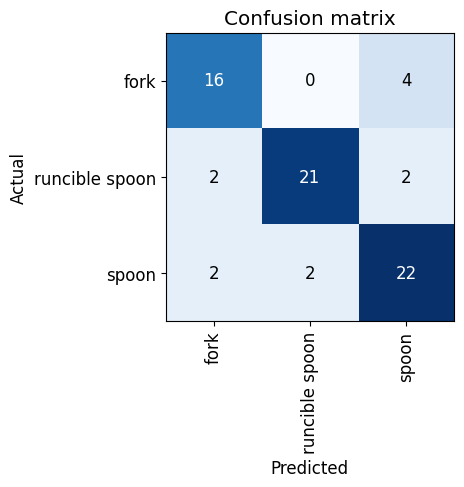

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

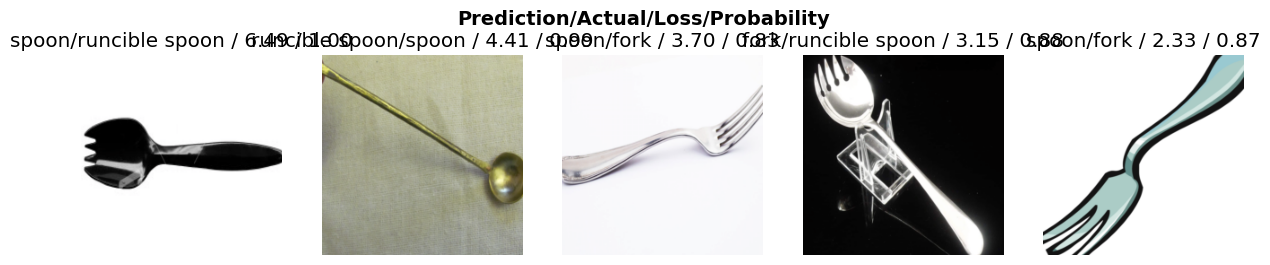

In [44]:
interp.plot_top_losses(5, nrows=1)

In [39]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


ValueError: not enough values to unpack (expected 4, got 3)

In [38]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

FileNotFoundError: [Errno 2] No such file or directory: 'utensils/spoon/75a054e8-02ad-456c-893e-fd8124c9705b.jpg'

In [23]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Error: Destination path 'utensils/spoon/ff99cdb3-57b0-43f8-a37a-0a957fc1636a.jpg' already exists

In [46]:
learn.export()

In [48]:
learn_inf = load_learner('export.pkl')

In [37]:
learn_inf = load_learner(path/'export.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'utensils/export.pkl'

In [49]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [50]:
img = PILImage.create(btn_upload.data[-1])

In [51]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [52]:
pred,pred_idx,probs = learn_inf.predict(img)

In [53]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: runcible spoon; Probability: 0.7458')